In [ ]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 5.3 MB/s 
     |████████████████████████████████| 46 kB 2.3 MB/s 
     |████████████████████████████████| 186 kB 40.1 MB/s 
     |████████████████████████████████| 1.2 MB 34.1 MB/s 
     |████████████████████████████████| 56 kB 3.0 MB/s 
     |████████████████████████████████| 51 kB 302 kB/s 
Mounted at /content/gdrive


In [ ]:
#hide
from fastbook import *
from fastai.vision.widgets import *

# **Gathering Dataset**

In [ ]:
key = os.environ.get('AZURE_SEARCH_KEY', '53c6e0b2d3404e3585744d3789767fcc')

In [ ]:
#def search_images_bing(key, term, min_sz=128, max_images=150) -- in the fastbook class
search_images_bing

<function fastbook.search_images_bing>

In [ ]:
results = search_images_bing(key, 'brown eyes')
ims = results.attrgot('contentUrl')
len(ims)

150

We've successfully downloaded the URLs of 150 brown colored eyes (or, at least, images that Bing Image Search finds for that search term).

**NB**: there's no way to be sure exactly what images a search like this will find. The results can change over time. * --ignore--We've heard of at least one case of a community member who found some unpleasant pictures of dead bears in their search results -- ignore*. You'll receive whatever images are found by the web search engine. If you're running this at work, or with kids, etc, then be cautious before you display the downloaded images.

Let's look at one:

In [ ]:
dest = 'images/brown_eye.jpg'
download_url(ims[10], dest)

Path('images/brown_eye.jpg')

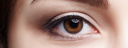

In [ ]:
im = Image.open(dest)
im.to_thumb(128,128)

This seems to have worked nicely, so let's use fastai's download_images to download all the URLs for each of our search terms. We'll put each in a separate folder:

In [ ]:
eye_colors = 'amber','blue','brown','gray','green','hazel','red'
path = Path('eye_colors')

In [ ]:
if not path.exists():
    path.mkdir()
    for color in eye_colors:
        dest = (path/color)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{color} eye')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [ ]:
fns = get_image_files(path)
print(fns)
print(f"\nthe eye colors have been added to their respective folders, \nthe number of pictures downloaded is {len(fns)}")

[Path('eye_colors/green/00000066.jpg'), Path('eye_colors/green/00000074.jpg'), Path('eye_colors/green/00000117.jpg'), Path('eye_colors/green/00000146.jpg'), Path('eye_colors/green/00000042.jpg'), Path('eye_colors/green/00000106.jpg'), Path('eye_colors/green/00000057.jpg'), Path('eye_colors/green/00000101.jpg'), Path('eye_colors/green/00000030.png'), Path('eye_colors/green/00000111.jpg'), Path('eye_colors/green/00000080.jpg'), Path('eye_colors/green/00000104.jpg'), Path('eye_colors/green/00000013.jpg'), Path('eye_colors/green/00000135.jpg'), Path('eye_colors/green/00000114.jpg'), Path('eye_colors/green/00000143.jpg'), Path('eye_colors/green/00000025.jpg'), Path('eye_colors/green/00000079.jpg'), Path('eye_colors/green/00000002.jpg'), Path('eye_colors/green/00000007.jpg'), Path('eye_colors/green/00000045.jpg'), Path('eye_colors/green/00000107.jpg'), Path('eye_colors/green/00000129.jpg'), Path('eye_colors/green/00000137.jpg'), Path('eye_colors/green/00000052.jpg'), Path('eye_colors/green/0

## **Running a check for corrupt images**

In [ ]:
failed = verify_images(fns)
print(f'The corrupt images are: {failed}\n')
print(f'There are {len(failed)} corrupt images')


The corrupt images are: [Path('eye_colors/green/00000144.jpg'), Path('eye_colors/hazel/00000052.jpg'), Path('eye_colors/hazel/00000095.jpg'), Path('eye_colors/red/00000102.jpg'), Path('eye_colors/gray/00000071.jpg'), Path('eye_colors/amber/00000110.jpg'), Path('eye_colors/amber/00000084.jpg'), Path('eye_colors/amber/00000108.jpg')]

There are 8 corrupt images


## Valid (incorrupt) image

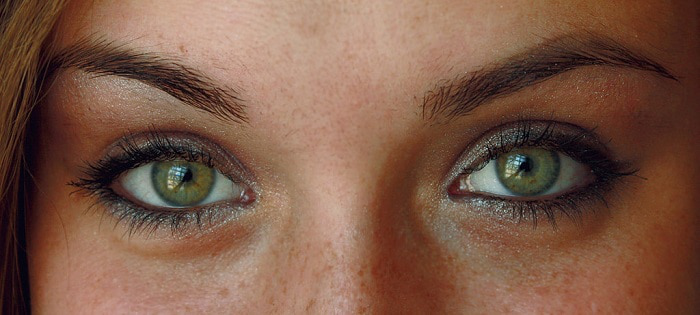

In [ ]:
Image.open(Path('eye_colors/green/00000145.jpg')) #valid image check

## Corrupt image: cannot be displayed: *UnidentifiedImageError *

In [ ]:
Image.open(failed[0])

UnidentifiedImageError: ignored

To remove all the failed images, you can use unlink on each of them. Note that, like most fastai functions that return a collection, verify_images returns an object of type L, which includes the map method. This (the map method) calls the passed function on each element of the collection (i.e failed)

In [ ]:
failed.map(Path.unlink);

## **From Data to Dataloaders**:

DataLoaders is a thin class that just stores whatever DataLoader objects you pass to it, and makes them available as train and valid. Although it's a very simple class, it's very important in fastai: it provides the data for your model. The key functionality in DataLoaders is provided with just these four lines of code (it has some other minor functionality we'll skip over for now):

```python
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])

```

>DataLoaders: A fastai class that stores multiple DataLoader objects you pass to it, normally a train and a valid, although it's possible to have as many as you like. The first two are made available as properties.





To turn our downloaded data into a DataLoaders object we need to tell fastai at least four things:

* What kinds of data we are working with
*How to get the list of items
*How to label these items
*How to create the validation set

# **Creating a Datablock**:
>The command gives us DataBlock object. It is like a template for creating a DataLoader. We still need to tell fastai the actual source of our data—in this case, the path where the images can be found:

In [ ]:
eyes = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

# **Loading the Data by passing the path to dataloader**

In [ ]:
dls = eyes.dataloaders(path)

>A DataLoaders includes validation and training DataLoaders. DataLoader is a class that provides batches of a few items at a time to the GPU. We'll be learning a lot more about this class in the next chapter. When you loop through a DataLoader fastai will give you 64 (by default) items at a time, all stacked up into a single tensor. We can take a look at a few of those items by calling the show_batch method on a DataLoader:

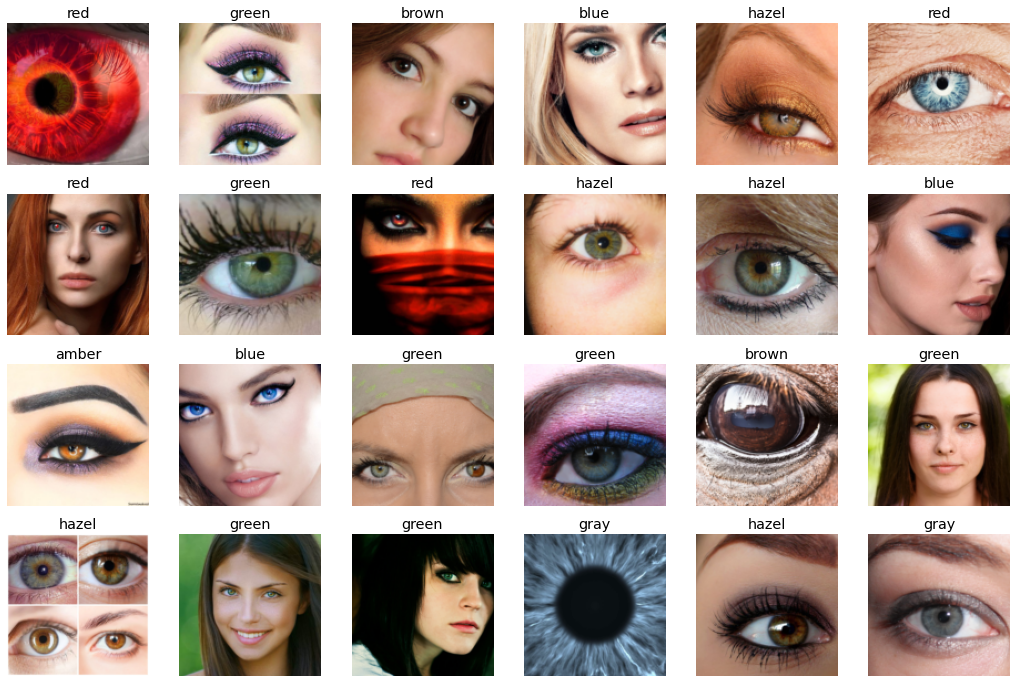

In [ ]:
dls.valid.show_batch(max_n=24, nrows=4)

>By default Resize crops the images to fit a square shape of the size requested, using the full width or height. This can result in losing some important details. Alternatively, you can ask fastai to pad the images with zeros (black), or squish/stretch them:

##**Squishing the images**

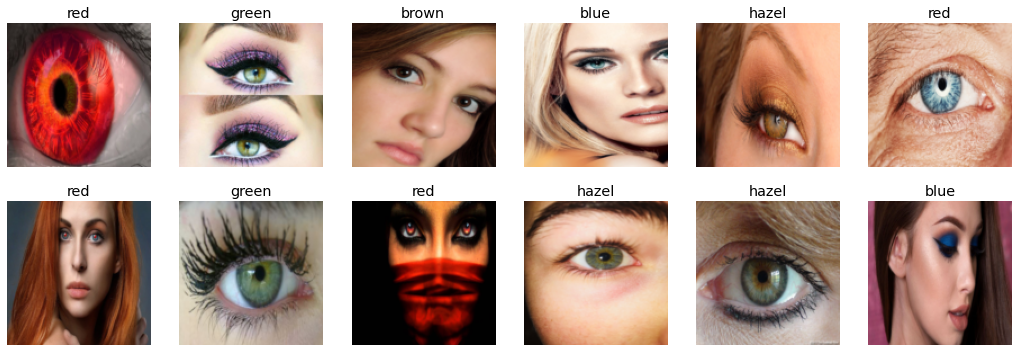

In [ ]:
eyes = eyes.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = eyes.dataloaders(path)
dls.valid.show_batch(max_n=12, nrows=2)

## **Padding with black**

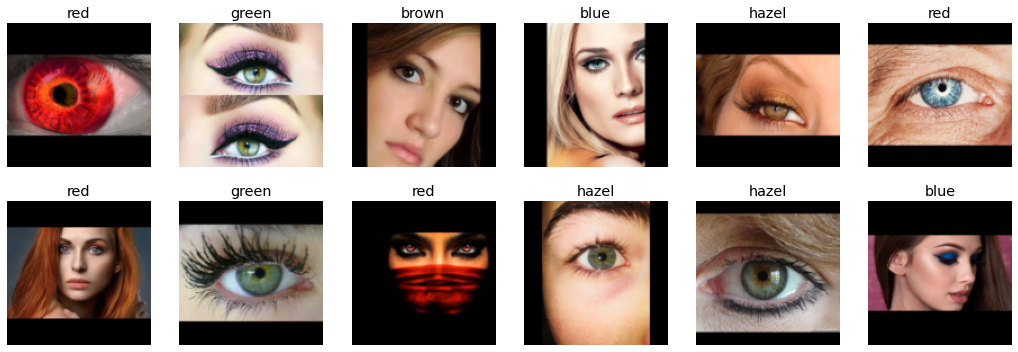

In [ ]:
bears = eyes.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = eyes.dataloaders(path)
dls.valid.show_batch(max_n=12, nrows=2)


All of these approaches seem somewhat wasteful, or problematic. If we squish or stretch the images they end up as unrealistic shapes, leading to a model that learns that things look different to how they actually are, which we would expect to result in lower accuracy. If we crop the images then we remove some of the features that allow us to perform recognition. For instance, if we were trying to recognize breeds of dog or cat, we might end up cropping out a key part of the body or the face necessary to distinguish between similar breeds. If we pad the images then we have a whole lot of empty space, which is just wasted computation for our model and results in a lower effective resolution for the part of the image we actually use.

Instead, what we normally do in practice is to randomly select part of the image, and crop to just that part. On each epoch (which is one complete pass through all of our images in the dataset) we randomly select a different part of each image. This means that our model can learn to focus on, and recognize, different features in our images. It also reflects how images work in the real world: different photos of the same thing may be framed in slightly different ways.

In fact, an entirely untrained neural network knows nothing whatsoever about how images behave. It doesn't even recognize that when an object is rotated by one degree, it still is a picture of the same thing! So actually training the neural network with examples of images where the objects are in slightly different places and slightly different sizes helps it to understand the basic concept of what an object is, and how it can be represented in an image.

Here's another example where we replace Resize with RandomResizedCrop, which is the transform that provides the behavior we just described. The most important parameter to pass in is min_scale, which determines how much of the image to select at minimum each time:

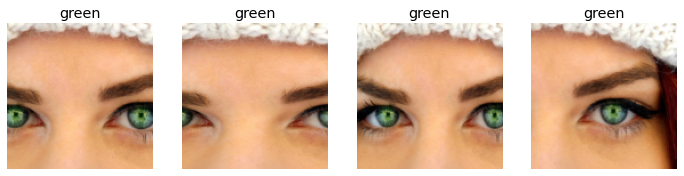

In [ ]:
eyes = eyes.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = eyes.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

We used unique=True to have the same image repeated with different versions of this RandomResizedCrop transform. This is a specific example of a more general technique, called data augmentation

# **Data Augmentation**

Data augmentation refers to creating random variations of our input data, such that they appear different, but do not actually change the meaning of the data. Examples of common data augmentation techniques for images are rotation, flipping, perspective warping, brightness changes and contrast changes. For natural photo images such as the ones we are using here, a standard set of augmentations that we have found work pretty well are provided with the aug_transforms function. Because our images are now all the same size, we can apply these augmentations to an entire batch of them using the GPU, which will save a lot of time. To tell fastai we want to use these transforms on a batch, we use the batch_tfms parameter (note that we're not using RandomResizedCrop in this example, so you can see the differences more clearly; we're also using double the amount of augmentation compared to the default, for the same reason):

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


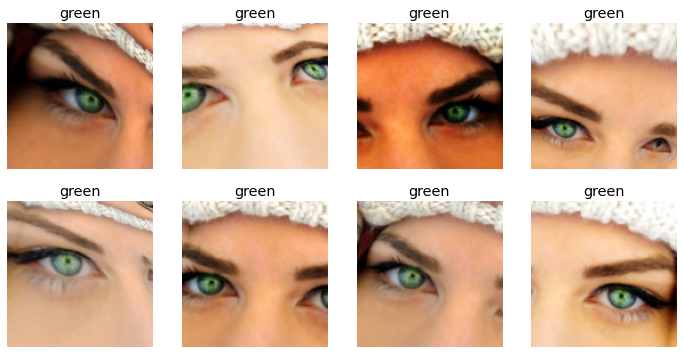

In [ ]:
eyes = eyes.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = eyes.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

Now the data is assembled for a format fit for training; we can actually train the data now.

# **Training the Model, and Using It to Clean the Data**

We don't have a lot of data for our problem (150 pictures of each sort of bear at most), so to train our model, we'll use RandomResizedCrop with an image size of 224 px, which is fairly standard for image classification, and default aug_transforms:

In [ ]:
eyes = eyes.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = eyes.dataloaders(path)

We can now create our Learner and fine-tune it in the usual way:

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(11)

Plotting the confusion matrix

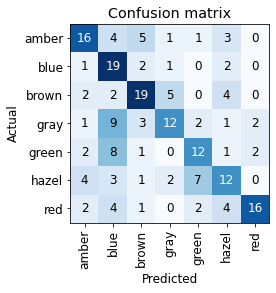

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

It's helpful to see where exactly our errors are occurring, to see whether they're due to a dataset problem (e.g., images that aren't eyes at all, or are labeled incorrectly, etc.), or a model problem (perhaps it isn't handling images taken with unusual lighting, or from a different angle, etc.). To do this, we can sort our images by their loss.

The loss is a number that is higher if the model is incorrect (especially if it's also confident of its incorrect answer), or if it's correct, but not confident of its correct answer. Now, plot_top_losses shows us the images with the highest loss in our dataset. As the title of the output says, each image is labeled with four things: prediction, actual (target label), loss, and probability. The probability here is the confidence level, from zero to one, that the model has assigned to its prediction:

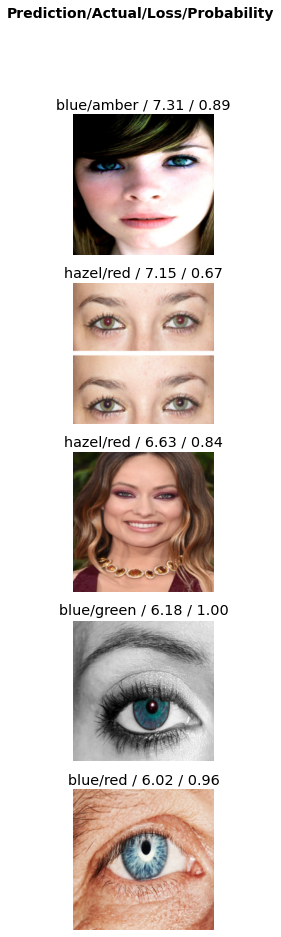

In [ ]:
interp.plot_top_losses(5, nrows=5)

This output shows that the image with the highest loss is one that has been predicted as "blue" with high confidence. However, it's labeled (based on our Bing image search) as "amber." We're not eye experts, but it sure looks to us like this label is incorrect! We should probably change its label to "blue."

The intuitive approach to doing data cleaning is to do it before you train a model. But as you've seen in this case, a model can actually help you find data issues more quickly and easily. So, we normally prefer to train a quick and simple model first, and then use it to help us with data cleaning.

fastai includes a handy GUI for data cleaning called ImageClassifierCleaner that allows you to choose a category and the training versus validation set and view the highest-loss images (in order), along with menus to allow images to be selected for removal or relabeling:

In [ ]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

So, for instance, to delete (unlink) all images selected for deletion, we would run:

In [ ]:
for idx in cleaner.delete(): 
  cleaner.fns[idx].unlink()

# **Exporting the model and making inferences**

fastai will save a file called export.pkl when you run ```learn.export()```

In [ ]:
learn.export()

checking to see if the file exist by using fastai's path class

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

## Loading the model file

In [ ]:
learn_inf = load_learner(path/'export.pkl')

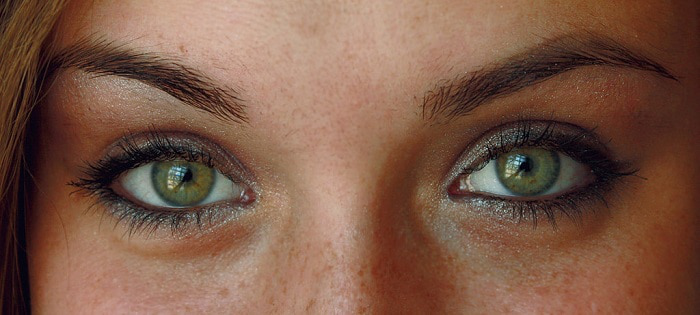

In [ ]:
Image.open(Path('eye_colors/green/00000145.jpg'))

In [ ]:
learn_inf.predict('eye_colors/green/00000145.jpg')

('green',
 tensor(4),
 tensor([9.3134e-05, 3.1936e-03, 4.4384e-04, 6.4696e-04, 9.6956e-01, 2.5894e-02, 1.6924e-04]))

Elements of the returned tuple:

1.   first: predicted category name
2.   second: The index in the tensor
3.   third: the probabilities of the 6 categories



In [ ]:
learn_inf.dls.vocab

['amber', 'blue', 'brown', 'gray', 'green', 'hazel', 'red']

We can see here that if we index into the vocab with the integer returned by predict then we get back "green," as expected. Also, note that if we index into the list of probabilities, we see a nearly 1.00 probability that this is a green eye.

We know how to make predictions from our saved model, so we have everything we need to start building our app. We can do it directly in a Jupyter notebook

# **Creating a Notebook App from the Model**

In [ ]:
eye_upload = widgets.FileUpload()
eye_upload

FileUpload(value={}, description='Upload')

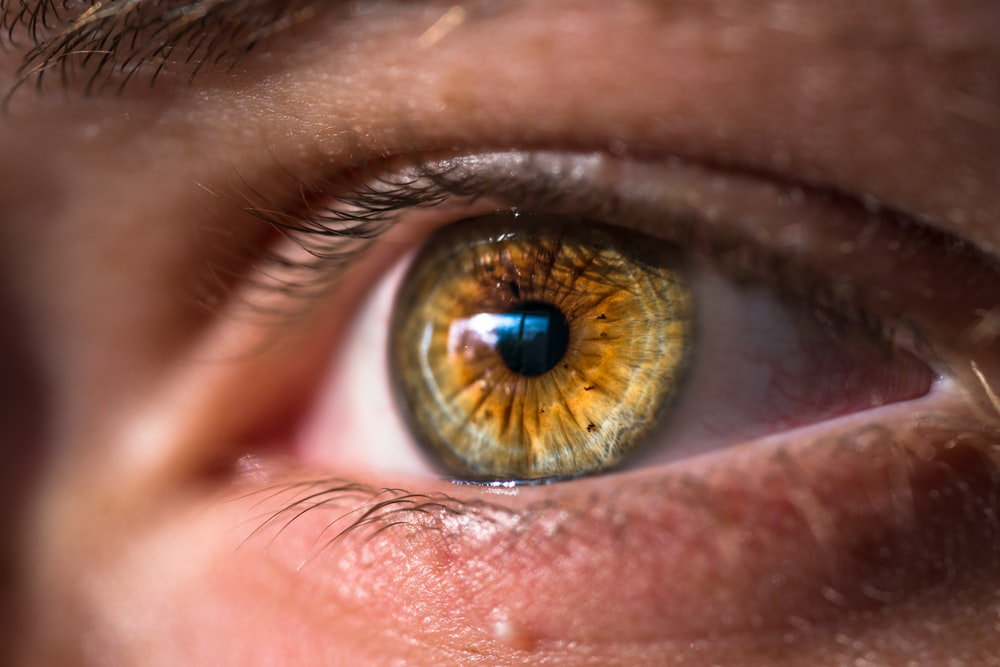

In [ ]:
img = PILImage.create(eye_upload.data[-1])
img

# Prediction

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img)

Displaying the prediction using a label

In [ ]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: hazel; Probability: 0.9042')

Output widget to display the picture

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

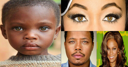

In [ ]:
#hide_output
eye_run = widgets.Button(description='Classify')
eye_run

Creating a click event handler: a function that will be executed when the classify button is clicked

In [ ]:
def on_click_classify(change):
    img = PILImage.create(eye_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
    print(lbl_pred.value)
eye_run.on_click(on_click_classify)


In [ ]:
eye_upload = widgets.FileUpload()


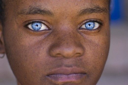

Prediction: blue; Probability: 0.6163


In [ ]:
VBox([widgets.Label('Select the eye!'), 
      eye_upload, eye_run, out_pl, lbl_pred])

# **Turning the Notebook into a real app**

In [ ]:
#hide
!pip install voila
!jupyter serverextension enable --sys-prefix voila

     |████████████████████████████████| 1.6 MB 5.2 MB/s 
     |████████████████████████████████| 393 kB 46.0 MB/s 
     |████████████████████████████████| 112 kB 44.7 MB/s 
     |████████████████████████████████| 551 kB 28.6 MB/s 
     |████████████████████████████████| 77 kB 4.8 MB/s 
     |████████████████████████████████| 52 kB 1.3 MB/s 
     |████████████████████████████████| 428 kB 45.3 MB/s 
  Attempting uninstall: tornado
    Found existing installation: tornado 5.1.1
    Uninstalling tornado-5.1.1:
      Successfully uninstalled tornado-5.1.1
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter-client 5.3.5
    Uninstalling jupyter-client-5.3.5:
      Successfully uninstalled jupyter-client-5.3.5
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are

Enabling: voila
- Writing config: /usr/etc/jupyter
    - Validating...
Error loading server extension voila
      X is voila importable?
